### 0. Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# to run matplotlib in the notebook instead of in a pop-up
%matplotlib inline 

### 1. Data loading
As the documentation for the dataset says , the data is provided in a text file with 26 columns of numbers separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

    1.	unit number  
    2.	time, in cycles  
    3.	operational setting 1  
    4.	operational setting 2  
    5.	operational setting 3  
    6.	sensor measurement 1  
    7.	sensor measurement 2  
    ...  
    26.	sensor measurement 26

As for the full list of the 21 sensors, here it is: 

<img src="assets/sensorlist1.png" width="350">

<img src="assets/sensorlist2.png" width="350">

In [4]:
# creating the columns following the documentation
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1, 22)] 
col_names = index_names + setting_names + sensor_names

# creating the dataframes to train and test our model

# training dataset (the one we will use to train our model) 
df_train = pd.read_csv('data/train.txt', sep=r'\s+', header=None, names=col_names)

# test dataset (the one we will use to try to predict with our trained model)
df_test = pd.read_csv('data/test.txt', sep=r'\s+', header=None, names=col_names)

# RUL dataset (the one we will use to check our answers on the test dataset as it contains the correct answers for it)
y_test = pd.read_csv('data/RUL.txt', sep=r'\s+', header=None, names=['RUL'])

# checking that the dataframes were properly created
print("Data loaded without an error")
print(f"Train dataframe dimensions : {df_train.shape}")
df_train.head()

Data loaded without an error
Train dataframe dimensions : (20631, 26)


,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


### 2. RUL calculation

The RUL (Remaining Useful Life) if not given to us in the "train" dataset but fortunately we can calculate it very easily by substracting the number of cycles passed through from the number of total cycles for the turbofan.

In [3]:
# creating a new dataframe containing the max amount in the "time_cycles" column for each "unit_nr" (turbofan) and naming it's columns
max_life = df_train.groupby('unit_nr')['time_cycles'].max().reset_index()
max_life.columns = ['unit_nr', 'max_life']

# merging this new dataframe with the "train" dateframe so we can access the data more efficiently
df_train = df_train.merge(max_life, on='unit_nr', how='left')

# calculating the RUL for each cycle in a new column
df_train['RUL'] = df_train['max_life'] - df_train['time_cycles']

# deleting the merged "max_life" column because we only needed it for the RUL calculation
df_train = df_train.drop(columns=['max_life'])

# chacking that everything went correctly
df_train[['unit_nr', 'time_cycles', 'RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


### 3. Data visualization

Before continuing, we will plot the data from some of the sensors to check how they are evolving, we are doing this to make sure our data is coherent. We will plot a few sensors for our first turbofan to see how the numbers are evolving as we approach the end of the RUL.

I will choose sensors s_2 (temperature at "beginning" of the turbofan), s_4 (temperature at "end" of the turbofan), s_7 (pressure), and s_12 (fan rotation speed) for this analysis because I am gessing that they exhibit strong correlation with engine degradation because as engine components degrade due to wear and tear, the engine loses efficiency. Because as we know, to maintain the required thrust level (controlled by the pilot), the engine control system compensates by increasing fuel flow and rotational speeds. This results in observable rising trends in temperatures (s_2, s_4) and pressures (s_7) over time, making them excellent predictors for RUL.

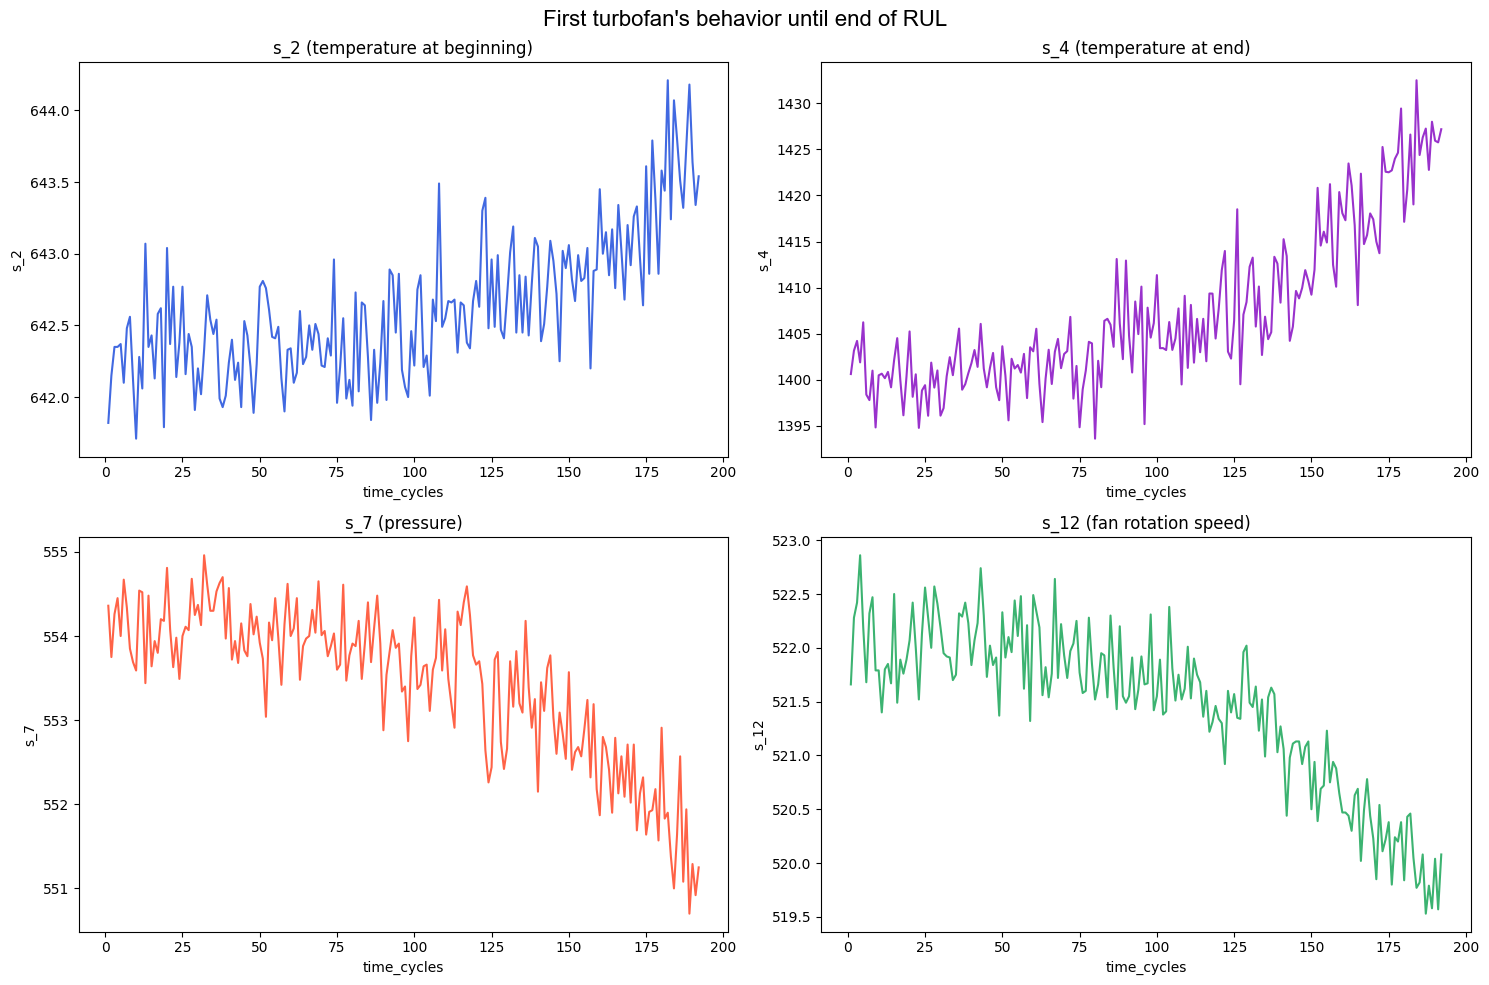

In [26]:
# creating a new dataframe containing only the first turbofan's data to plot it
turbofan_1 = df_train[df_train['unit_nr'] == 1]

# creating the figure that we will plot on
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('First turbofan\'s behavior until end of RUL', fontsize=16, family="Arial")

# initializing some variables we will need for our plot
sensors_to_plot = ["s_2", "s_4", "s_7", "s_12"]
subplot_titles = ["s_2 (temperature at beginning)", "s_4 (temperature at end)", "s_7 (pressure)", "s_12 (fan rotation speed)"]
subplot_colors = ["royalblue","darkorchid","tomato","mediumseagreen"]
axes_to_plot = [[0,0],[0,1],[1,0],[1,1]]

# plotting with seaborn while using our newly made dataframe and our variables as parameters
for i in range(4):
    row, col = axes_to_plot[i]
    sns.lineplot(data=turbofan_1, x='time_cycles', y=sensors_to_plot[i], ax=axes[row, col], color=subplot_colors[i]).set(title=subplot_titles[i])

# using the layout function to avoid overlapping with our four plots and displaying the plot
plt.tight_layout()
plt.show()

Now we can try to deduce something from these plots, why do sensors react this way? 

* Rising temperatures (s_2, s_4): the extra fuel consumption creates more heat, causing temperatures (especially at the outlet, so s_4) to rise significantly as the engine approaches failure.

* Dropping pressures (s_7): degradation often involves gaps widening between blades and casing. This leads to air leakage and a loss of compression efficiency, causing pressure readings to drop.

* Dropping fan speed (s_12): as the engine blades wear down the fan experiences more "drag" (resistance) and struggles to maintain its optimal rotation speed.

### 4. Plot smoothing

As we can see, the sensors are prone to a lot of noise that make the plots unclear or harder to read, so we will now smooth these plots with a calculated moving average to have a nicely shaped curve.

In [ ]:
# creating a new dataframe containing only the first turbofan's data to smoothly plot it
df_train_smooth = df_train[df_train['unit_nr'] == 1]

for i in sensors_to_plot:
    df_train_smooth[sensor] = df_train_smooth.groupby('unit_nr')[capteur].transform(data.rolling(window=5).mean())

# plotting again with the same parameters but this time using the "smooth" data
for i in range(4):
    row, col = axes_to_plot[i]
    sns.lineplot(data=df_train_smooth, x='time_cycles', y=sensors_to_plot[i], ax=axes[row, col], color=subplot_colors[i]).set(title=subplot_titles[i])

plt.tight_layout()
plt.show()